# Lab 2 - Classification

The goal of today's lab is to code the K-Nearest Neighbors, Naive Bayes, and Decision Tree algorithms by hand.

I have included some starter code for the three classification algorithms. Each of them has missing components that need to be completed (marked by **TODO**). Your task is to fill in the missing code and compare your results to sklearn's algorithms. Each of the missing elements can be written in one line of code but you are encouraged to add more as you see fit.

Note these are simplistic and inefficient implementations of the algorithms and should not be used in practice. However, it is good experience to code them by hand and get a better understanding of how the algorithms work behind-the-scenes.

If you get stuck on one specific algorithm, move on to the next. We will discuss the full results as a class, and I will release the solutions after lab. There is nothing to submit for this lab.

Once you finish all 3 algorithms, there are a series of discussion questions for you to consider as a group. We will discuss this as a class but they will not be included in the solution.

### Miscellaneous Code

In [145]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter


Evaluate prediction classification, determines if there are any samples that don't match (returns first that does not match)

In [146]:
def eval_preds(our_preds, sklearn_preds):
    assert len(our_preds) == len(sklearn_preds)
    for i in range(len(our_preds)):
        if our_preds[i] == sklearn_preds[i]:
            continue
        else:
            print(f"ERROR at prediction {i}")
            break
    print("CORRECT :)")

## KNN

### Data

For KNN, we will use the Banknote Authentication Dataset (https://archive.ics.uci.edu/dataset/267/banknote+authentication) 
The dataset contains 1372 instances and 5 attributes. The task is to predict whether a banknote is authentic (0) or a forgery (1)

In [147]:
# Read in dataset
banknote = pd.read_csv("data_banknote_authentication.txt", header=None)
# Rename Columns
banknote.columns = ["Variance", "Skewness", "Curtosis", "Entropy", "Class"]
# Separate X (features) and y (label/class)
X_banknote = banknote[["Variance", "Skewness", "Curtosis", "Entropy"]]
y_banknote = banknote['Class']

In [148]:
#Prints first 5 rows of input feature dataset.
X_banknote.head()

,Variance,Skewness,Curtosis,Entropy
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


In [149]:
#Prints first 5 rows of input label dataset.
y_banknote.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [150]:
# Divide into train and test datasets
#Divides dataset into 80% train, 20% test.

X_banknote_train, X_banknote_test, y_banknote_train, y_banknote_test = train_test_split(X_banknote, 
                                                                                        y_banknote, 
                                                                                        test_size=.2, 
                                                                                        random_state=12345)

### Algorithm

In [151]:
#Given a test data set, use the training dataset to calculate distance to the testing point and 
def knn_predict_all(X_train: pd.DataFrame, y_train:pd.DataFrame, X_test: pd.DataFrame, k=5):
    preds = []
    for _, row in X_test.iterrows():
        preds.append(knn_predict_one(X_train, y_train, row, k))
    return preds

In [152]:
def knn_predict_one(X_train: pd.DataFrame, y_train:pd.DataFrame, test_row: pd.DataFrame, k):
    distances = []
    for idx, train_row in X_train.iterrows():
        distance = sum((train_row - test_row)**2)**0.5 # Compute Euclidean distance
        distances.append(distance)
    #Create array containing distances to all training datapoint 
    distances = pd.Series(distances, index=y_train.index)
    sorted_distances = distances.sort_values()
    #This is a 5 element vector with the shortest distance 
    shortest_k_distances = sorted_distances[:k] # TODO: get the k instances that are closest to the test_row
    #Selects the most popular class from the shortest k distances.
    # TODO: predict the test row from those k instances
    # Get the indices of the k nearest neighbors
    k_nearest_indices = shortest_k_distances.index
    
    # Get the classes of the k nearest neighbors
    k_nearest_classes = y_train.loc[k_nearest_indices]
    
    # Select the most popular class from the k nearest neighbors
    most_common_class = Counter(k_nearest_classes).most_common(1)[0][0]
    
    return pred

In [153]:
k = 5 # Feel free to change this as you see fit, but you should only use odd numbers

In [154]:
our_knn_preds = knn_predict_all(X_banknote_train, y_banknote_train, X_banknote_test, k)

NameError: name 'pred' is not defined

In [ ]:
# Sklearn KNN
knn_mdl = KNeighborsClassifier(n_neighbors=k)
knn_mdl.fit(X_banknote_train, y_banknote_train)
sklearn_knn_preds = knn_mdl.predict(X_banknote_test)

In [ ]:
eval_preds(our_knn_preds, sklearn_knn_preds)

## Naive Bayes

### Data

For Naive Bayes, we will use a custom dataset of Notre Dame Football games since 1992. The task is to predict whether or not Notre Dame will win a football game. The features are all categorical or binary. In the result category, 

In [ ]:
# Read in dataset
nd = pd.read_csv("nd_results.csv")

# Separate into train and test data
nd_train = nd.loc[nd['Year'] <= 2021, ]
nd_test = nd.loc[nd['Year'] == 2022, ]
nd_test.loc[nd_test['OppConf'] == 'Sun Belt', 'OppConf'] = 'CUSA' # Change Marshall's conference for simplicity

# Integer Encode the Conference - We must do this for sklearn (our implementation would work regardless)
enc = OrdinalEncoder()
nd_train = pd.DataFrame(enc.fit_transform(nd_train[["IsNDRanked", "IsOppRanked", "OppConf", "Result"]]), index=nd_train.index, columns=["IsNDRanked", "IsOppRanked", "OppConf", "Result"])
nd_test = pd.DataFrame(enc.transform(nd_test[["IsNDRanked", "IsOppRanked", "OppConf", "Result"]]), index=nd_test.index, columns=["IsNDRanked", "IsOppRanked", "OppConf", "Result"])

# Separate X (features) and y (label/class)
X_nd_train = nd_train[["IsNDRanked", "IsOppRanked", "OppConf"]].reset_index(drop=True)
y_nd_train = nd_train['Result'].reset_index(drop=True)
X_nd_test = nd_test[["IsNDRanked", "IsOppRanked", "OppConf"]].reset_index(drop=True)
y_nd_test = nd_test['Result'].reset_index(drop=True)

In [ ]:
X_nd_train.head()

In [ ]:
y_nd_train.head()

### Algorithm

In [ ]:
def nb_predict_all(X_train: pd.DataFrame, y_train:pd.DataFrame, X_test: pd.DataFrame):
    preds = []
    for _, row in X_test.iterrows():
        preds.append(nb_predict_one(X_train, y_train, row))
    return preds

In [ ]:
def nb_predict_one(X_train: pd.DataFrame, y_train: pd.DataFrame, row: pd.DataFrame):
    max_prob = 0.0 # Why 0?
    best_pred = np.nan
    for pred in [0,1]:
        total_prob = 1 # Why 1?
        for col in row.index:
            p_x_given_y = # TODO: Calculate P(X|Y)
            total_prob *= p_x_given_y
        p_y  =  # TODO: Calculate P(Y)
        total_prob *= p_y
        if total_prob >= max_prob:
            best_pred = pred
            max_prob = total_prob
    return best_pred

In [ ]:
our_nb_preds = nb_predict_all(X_nd_train, y_nd_train, X_nd_test)

In [ ]:
# Sklearn NB
nb_mdl = CategoricalNB(alpha=1)
nb_mdl.fit(X_nd_train, y_nd_train)
sklearn_nb_preds = nb_mdl.predict(X_nd_test)

In [155]:
eval_preds(our_nb_preds, sklearn_nb_preds)

NameError: name 'our_nb_preds' is not defined

## Decision Tree

### Data

For the Decision Tree we will use the same Weather Dataset from the class lecture.

In [ ]:
weather = pd.DataFrame([['Sunny', 'Hot', 'High', 'False', 'No'],
                       ['Sunny', 'Hot', 'High', 'True', 'No'],
                       ['Overcast', 'Hot', 'High', 'False', 'Yes'],
                       ['Rainy', 'Mild', 'High', 'False', 'Yes'],
                       ['Rainy', 'Cool', 'Normal', 'False', 'Yes'],
                       ['Rainy', 'Cool', 'Normal', 'True', 'No'],
                       ['Overcast', 'Cool', 'Normal', 'True', 'Yes'],
                       ['Sunny', 'Mild', 'High', 'False', 'No'],
                       ['Sunny', 'Cool', 'Normal', 'False', 'Yes'],
                       ['Rainy', 'Mild', 'Normal', 'False', 'Yes'],
                       ['Sunny', 'Mild', 'Normal', 'True', 'Yes'],
                       ['Overcast', 'Mild', 'High', 'True', 'Yes'],
                       ['Overcast', 'Hot', 'Normal', 'False', 'Yes'],
                       ['Rainy', 'Mild', 'High', 'True', 'No']], 
                       columns=['Outlook', 'Temperature', 'Humidity', 'Windy', 'Play?'])

### Algorithm

Unlike the other algorithms, we wlil not write the entire Decision Tree algorithm for time/space considerations. Instead we will focus simply on the splitting criteria: Information Gain, Gain Ratio, and Gini Index.

In [156]:
def get_y_entropy():
    cnt_play_no = weather[weather['Play?']=='No'].shape[0]
    cnt_play_yes = weather[weather['Play?']=='Yes'].shape[0]
    cnt_total = weather.shape[0]
    entropy_y = # TODO: Calculate entropy for y. (Hint: you can use np.log2 for the logarithm)
    return entropy_y

SyntaxError: invalid syntax (2109655371.py, line 5)

In [157]:
def get_column_entropy(column):
    entropy_column = 0
    for value in weather[column].unique():
        cnt_column_val = weather[weather[column] == value].shape[0]
        cnt_column_val_no = weather[(weather[column] == value) & ((weather['Play?'] == 'No'))].shape[0]
        cnt_column_val_yes = weather[(weather[column] == value) & ((weather['Play?'] == 'Yes'))].shape[0]
        
        prob_column = cnt_column_val / weather.shape[0]
        if cnt_column_val_no > 0: # Have to do this because log(0) doesn't exist
            conditional_entropy_no = cnt_column_val_no/cnt_column_val*np.log2(cnt_column_val_no/cnt_column_val)
        else:
            conditional_entropy_no = 0
        if cnt_column_val_yes > 0:
            conditional_entropy_yes = cnt_column_val_yes/cnt_column_val*np.log2(cnt_column_val_yes/cnt_column_val)
        else:
            conditional_entropy_yes = 0
        
        entropy_column += # TODO: Add the entropy for this value to the running total for the column
    return entropy_column

SyntaxError: invalid syntax (3192341054.py, line 18)

In [158]:
def get_information_gain(column):
    entropy_y = get_y_entropy()
    column_entropy = get_column_entropy(column)
    ig = # TODO: Calculate Information Gain
    return ig

SyntaxError: invalid syntax (3631753382.py, line 4)

In [159]:
for col in weather.columns:
    if col == 'Play?':
        continue
    print(f"IG(Y|{col}): {round(get_information_gain(col), 2)}")

NameError: name 'get_information_gain' is not defined

<font color='red'>**Correct Answer:**

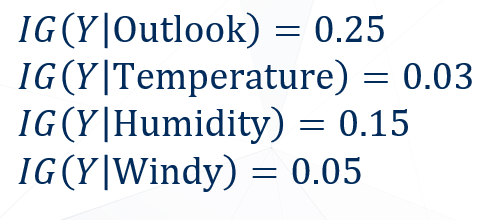

In [160]:
def get_split_info(column):
    split_info = 0
    for value in weather[column].unique():
        size_split = weather[weather[column] == value].shape[0]
        size_all_splits = weather.shape[0]
        split_info += -size_split/size_all_splits*np.log2(size_split/size_all_splits)
    return split_info

In [161]:
def get_gain_ratio(column):
    information_gain = get_information_gain(column)
    split_info = get_split_info(column)
    gr = # TODO: Calculate Gain Ratio
    return gr

SyntaxError: invalid syntax (2965570132.py, line 4)

In [162]:
for col in weather.columns:
    if col == 'Play?':
        continue
    print(f"GR(Y|{col}): {round(get_gain_ratio(col), 2)}")

NameError: name 'get_gain_ratio' is not defined

<font color='red'>**Correct Answer:**

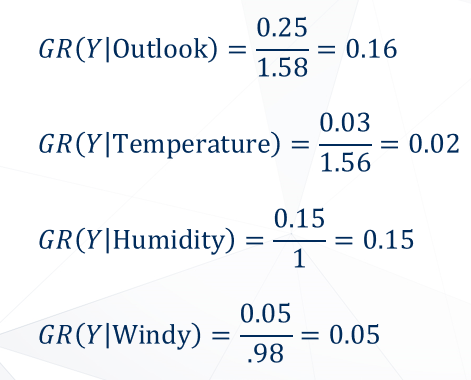

In [163]:
def get_gini_index_y():
    p_yes = sum(weather['Play?']=='Yes')/weather['Play?'].shape[0]
    p_no = sum(weather['Play?']=='No')/weather['Play?'].shape[0]
    gi = # TODO: Calculate Gini Index
    return gi

SyntaxError: invalid syntax (1841875809.py, line 4)

In [164]:
def get_gini_index_col(column):
    gi = 0
    for value in weather[column].unique():
        p_col = sum(weather[column]==value) / weather.shape[0]
        p_col_no = sum((weather[column] == value) & (weather['Play?'] == 'No')) / sum(weather[column]==value)
        p_col_yes = sum((weather[column] == value) & (weather['Play?'] == 'Yes')) / sum(weather[column]==value)
        gi += # TODO: Add Gini Index for value to running total for column
    return gi

SyntaxError: invalid syntax (516091058.py, line 7)

In [165]:
def get_delta_gini_index_col(column):
    gi_y = get_gini_index_y()
    gi_col = get_gini_index_col(column)
    delta_gi = # TODO: Calculate Delta GI
    return delta_gi

SyntaxError: invalid syntax (2289762884.py, line 4)

In [166]:
for col in weather.columns:
    if col == 'Play?':
        continue
    print(f"\u0394GI(Y|{col}): {round(get_delta_gini_index_col(col), 2)}")

NameError: name 'get_delta_gini_index_col' is not defined

<font color='red'>**Correct Answer:**

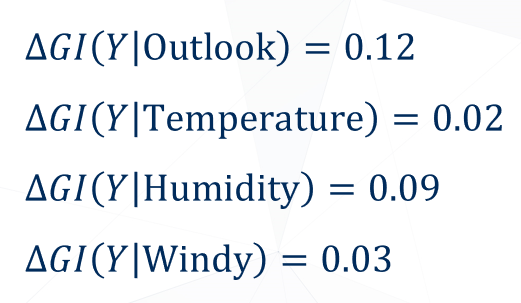

## Discussion Questions

0) Why do I say you should only use an odd number for k in KNN?

1) In the ND results dataset, I changed Marshall's conference from Sun Belt to CUSA to simplify our model. Why was this necessary? 

2) Now that we calculated the Information Gain, Gain Ratio, and Gini Index for each of the columns, which column is the optional split point for each metric?

3) Why did we use different datasets for KNN and Naive Bayes? Is there something about these datasets that's makes one easier for each algorithm?

4) What impact (if any) does the Curse of Dimensionality have on KNN, Naive Bayes, and Decision Trees?

5) What would happen if you were to test a KNN on the training set with k=1?

6) For which algorithms that we discussed should you use normalize/standardize your data?

7) What impact would a small training set have on each of the algorithms? What about an imbalanced training set?